# Caso Práctico 2
## Modelo de Inteligencia Artificial para predecir el tipo de reaccion química 
### Equipo:
* Héctor Manuel Godínez Lozano
* José de Jesús González Hernández
* Diana Romina Miranda Grijalva

### Calcular FP desde las reacciones de SMILES
En esta primera sección, utilizamos el paquete `rxnfp` para generar fingerprints moleculares a partir de las representaciones SMILES (Simplified Molecular Input Line Entry System) de las reacciones químicas. Los fingerprints son vectores numéricos que capturan características clave de las reacciones, lo que nos permite posteriormente hacer predicciones sobre el tipo de reacción.

### Importación de librerías

#### Carga del modelo y tokenizer
También cargamos el modelo preentrenado RXN-BERT y su tokenizer. Estos componentes son esenciales para la generación de fingerprints, ya que RXN-BERT está diseñado para aprender representaciones a partir de reacciones químicas.

In [10]:
import gzip
import pandas as pd
import numpy as np
from itertools import islice
from tqdm import tqdm, tqdm_notebook
from rxnfp.transformer_fingerprints import (
    RXNBERTFingerprintGenerator, get_default_model_and_tokenizer, generate_fingerprints
)

En este paso, get_default_model_and_tokenizer() obtiene un modelo BERT preentrenado y su tokenizer asociado, mientras que RXNBERTFingerprintGenerator se encarga de convertir las representaciones de las reacciones en fingerprints.

### Ejemplo de conversión de SMILES a fingerprint
Para mostrar cómo funciona el generador, tomamos una reacción de ejemplo en formato SMILES y la convertimos en su correspondiente fingerprint. Este fingerprint es un vector numérico que representa la reacción.

In [11]:
from rxnfp.transformer_fingerprints import (
    RXNBERTFingerprintGenerator, get_default_model_and_tokenizer, generate_fingerprints
)

model, tokenizer = get_default_model_and_tokenizer()

rxnfp_generator = RXNBERTFingerprintGenerator(model, tokenizer)

example_rxn = "Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1"

fp = rxnfp_generator.convert(example_rxn)
print(len(fp))
print(fp[:5])

256
[-2.0174953937530518, 1.7602031230926514, -1.3323533535003662, -1.1095026731491089, 1.2254550457000732]


### Carga del Dataset y Creación del DataFrame
Ahora, cargamos el dataset que contiene una lista de reacciones químicas junto con su clasificación en tipos de reacciones. El dataset proviene de un archivo .tsv que utilizamos del github "RXNFP".

In [12]:
df = pd.read_csv('rxnfp/data/schneider50k.tsv', sep='\t')
df.head()

Unnamed: 0                                       original_rxn rxn_class  \
0           0  [CH3:17][S:14](=[O:15])(=[O:16])[N:11]1[CH2:10...     6.1.5   
1           1  O.O.[Na+].[CH3:1][c:2]1[cH:7][c:6]([N+:8](=O)[...     7.1.1   
2           2  [CH3:1][O:2][c:3]1[cH:4][cH:5][c:6](-[c:9]2[cH...     1.8.5   
3           3  Cl.[CH3:43][CH2:42][S:44](=[O:45])(=[O:46])Cl....     2.2.3   
4           4  [CH3:25][O:24][c:21]1[cH:22][cH:23][c:17]([O:1...     1.3.7   

       source                                                rxn  split  
0  US06887874  C1CCCCC1.CCO.CS(=O)(=O)N1CCN(Cc2ccccc2)CC1.[OH...   test  
1  US07056926  CCOC(C)=O.Cc1cc([N+](=O)[O-])ccc1NC(=O)c1ccccc...   test  
2  US08492378  COc1ccc(-c2coc3ccc(-c4nnc(S)o4)cc23)cc1.COc1cc...   test  
3  US08592454  CCS(=O)(=O)Cl.CN(C(=O)N(C)[C@@H]1CN(C(=O)C2CCN...  train  
4  US06716851  COc1ccc(OC)c(N)c1.Cc1cc(Cl)nc(-c2ccccn2)n1>>CO...   test

### Selección de columnas relevantes
Creamos un nuevo DataFrame fps que contiene únicamente las columnas necesarias para nuestro análisis: la clase de reacción (rxn_class) y la propia reacción representada en SMILES (rxn).

In [13]:
fps = df[['rxn_class', 'rxn']]
fps.head()

rxn_class                                                rxn
0     6.1.5  C1CCCCC1.CCO.CS(=O)(=O)N1CCN(Cc2ccccc2)CC1.[OH...
1     7.1.1  CCOC(C)=O.Cc1cc([N+](=O)[O-])ccc1NC(=O)c1ccccc...
2     1.8.5  COc1ccc(-c2coc3ccc(-c4nnc(S)o4)cc23)cc1.COc1cc...
3     2.2.3  CCS(=O)(=O)Cl.CN(C(=O)N(C)[C@@H]1CN(C(=O)C2CCN...
4     1.3.7  COc1ccc(OC)c(N)c1.Cc1cc(Cl)nc(-c2ccccn2)n1>>CO...

El propósito de esta operación es simplificar los datos y enfocarnos únicamente en las columnas que serán necesarias para generar los fingerprints y entrenar el modelo más adelante.

### Generación de Fingerprints para el Conjunto de Reacciones:
En este paso, generamos los fingerprints de todas las reacciones en el DataFrame fps utilizando el generador de RXN-BERT. Sin embargo, dado que el proceso de cálculo es computacionalmente costoso, opté por utilizar una muestra ajustada de 10k reacciones, lo que permite que el cómputo sea más eficiente.

#### Nota importante:
El cálculo de fingerprints puede ser lento en máquinas con recursos limitados, por lo que decidimos trabajar con una muestra ajustada de 10k reacciones. En aplicaciones más robustas, se recomienda realizar este cálculo en máquinas con mayor capacidad de procesamiento o paralelizar las tareas en un entorno distribuido.


In [14]:
from rxnfp.transformer_fingerprints import (
    RXNBERTFingerprintGenerator, get_default_model_and_tokenizer, generate_fingerprints
)

# Cargar modelo y tokenizer
model, tokenizer = get_default_model_and_tokenizer()

# Inicializar generador de fingerprints
rxnfp_generator = RXNBERTFingerprintGenerator(model, tokenizer)

# Aplicar la generación de fingerprints a cada reacción en el DataFrame 'fps'
fps['fingerprint'] = fps['rxn'].apply(lambda rxn: rxnfp_generator.convert(rxn))

# Revisar las primeras filas del DataFrame con los fingerprints generados
fps.head()


KeyboardInterrupt: 

Aquí aplicamos la función convert() de RXN-BERT a cada reacción en el DataFrame, lo que genera un fingerprint único para cada una. Finalmente, revisamos las primeras filas para verificar que los fingerprints han sido generados correctamente.

### RESULTADOS - Clasificacion
Explicación de la Clasificación y Evaluación del Modelo de Reacciones Químicas

Configuración de las Bibliotecas y Funciones de Evaluación
Antes de entrenar un modelo, hemos importado las bibliotecas necesarias para la clasificación, como LogisticRegression de sklearn, y algunas funciones personalizadas que ayudan a evaluar el modelo.

In [15]:
import json
import copy
import random
import pandas as pd
import numpy as np
from sklearn import metrics
import random
from sklearn.linear_model import LogisticRegression

La función evaluate_model es crítica porque calcula la matriz de confusión y las métricas de rendimiento, como el recall, precision, y F-score, que son fundamentales para medir la efectividad del modelo en predecir correctamente las clases de reacción química.

Adicionalmente, la función labelled_cmat crea una visualización de la matriz de confusión, lo que nos permite ver gráficamente qué tan bien o mal el modelo está clasificando las reacciones químicas. Esto es particularmente útil para detectar patrones de confusión entre las diferentes clases de reacciones.

In [16]:
def evaluate_model(model, fingerprints, corresponding_classes, all_classes, all_classes_names):
    
    preds = model.predict(fingerprints)
    predicted_classes = [all_classes[x] for x in preds]
    expected_classes =[all_classes[x] for x in corresponding_classes]

    confusion_matrix = metrics.confusion_matrix(corresponding_classes, preds)
    colCounts = confusion_matrix.sum(axis=0)
    rowCounts = confusion_matrix.sum(axis=1)

    print(' & recall & prec & F-score  &   reaction class &  \\\\ ')
    sum_recall=0
    sum_prec=0
    for i, rxn_class in enumerate(all_classes):
        recall = 0
        if rowCounts[i] > 0:
            recall = float(confusion_matrix[i,i])/rowCounts[i]
        sum_recall += recall
        prec = 0
        if colCounts[i] > 0:
            prec = float(confusion_matrix[i,i])/colCounts[i]
        sum_prec += prec
        f_score = 0
        if (recall + prec) > 0:
            f_score = 2 * (recall * prec) / (recall + prec)   
        print('{:2d} & {:.4f} & {:.4f} &{:.4f} & {:9s} &{:s} \\\\'.format(i, recall, prec, f_score, all_classes_names[rxn_class], rxn_class))
    
    mean_recall = sum_recall/len(all_classes)
    mean_prec = sum_prec/len(all_classes)
    if (mean_recall+mean_prec) > 0:
        mean_fscore = 2*(mean_recall*mean_prec)/(mean_recall+mean_prec)
    print(" &  {:.2f} & {:.2f} & {:.2f} & Average & \\\\ ".format(mean_recall,mean_prec,mean_fscore))
    
    return confusion_matrix

def labelled_cmat(confusion_matrix, labels,
                  figsize=(20,15), label_extras=None, 
                  dpi=300,threshold=0.01, 
                  xlabel=True, ylabel=True, rotation=90):
    from matplotlib import pyplot as plt
    
    rowCounts = confusion_matrix.sum(axis=1)
    cmat_percent = confusion_matrix/rowCounts[:,None]
    #zero all elements that are less than 1% of the row contents
    ncm = cmat_percent*(cmat_percent>threshold)

    fig = plt.figure(1,figsize=figsize,dpi=dpi)
    ax = fig.add_subplot(1,1,1)
    fig.set_size_inches(figsize)
    fig.set_dpi(dpi)
    # pax=ax.pcolor(ncm,cmap=cm.ocean_r)
    # pax=ax.pcolor(ncm,cmap='gist_earth_r')

    pax=ax.pcolor(ncm,cmap='terrain_r')
    ax.set_frame_on(True)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(confusion_matrix.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(confusion_matrix.shape[1])+0.5, minor=False)

    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    if label_extras is not None:
        labels = [' {:s} {:s}'.format(x,label_extras[x].strip()) for x in labels]
    
    ax.set_xticklabels([], minor=False) 
    ax.set_yticklabels([], minor=False)

    if xlabel:
        ax.set_xticklabels(labels, minor=False, rotation=rotation, horizontalalignment='left') 
    if ylabel:
        ax.set_yticklabels(labels, minor=False)

    ax.grid(True)
    fig.colorbar(pax)
    fig.tight_layout()
    return fig

### Carga y Preparación de Clases de Reacción:
Para clasificar correctamente las reacciones, cargamos los archivos rxnclass2id.json y rxnclass2name.json, que contienen los identificadores numéricos y los nombres de las clases de reacción, respectivamente. Estos archivos nos permiten mapear las clases de reacción químicas a un formato que sea entendible por el modelo y para nosotros durante la evaluación.

In [17]:
with open('rxnfp/data/rxnclass2id.json', 'r') as f:
    rxnclass2id = json.load(f)

with open('rxnfp/data/rxnclass2name.json', 'r') as f:
    rxnclass2name = json.load(f)
all_classes =sorted(rxnclass2id.keys())

### Cargar Fingerprints Preentrenados:
El archivo TSV que cargamos, schneider50k.tsv, contiene los datos de 50,000 reacciones químicas y su clasificación asociada. Para esta tarea, hemos generado y cargado los fingerprints preentrenados de dos formas diferentes:

* ft_10k_fps: Fingerprints ajustados a 10,000 reacciones.
* ft_pretrained: Fingerprints preentrenados en un modelo más grande.

Estos fingerprints representan las características únicas de cada reacción, que el modelo de clasificación utilizará para hacer predicciones.

In [18]:
import pickle
schneider_df = pd.read_csv('rxnfp/data/schneider50k.tsv', sep='\t', index_col=0)
ft_10k_fps = np.load('rxnfp/data/fps_ft_10k.npz')['fps']
ft_pretrained = np.load('rxnfp/data/fps_pretrained.npz')['fps']
schneider_df['ft_10k'] = [fp for fp in ft_10k_fps]
schneider_df['ft_pretrained'] = [fp for fp in ft_pretrained]
schneider_df['class_id'] = [rxnclass2id[c] for c in schneider_df.rxn_class]
schneider_df.head()

original_rxn rxn_class      source  \
0  [CH3:17][S:14](=[O:15])(=[O:16])[N:11]1[CH2:10...     6.1.5  US06887874   
1  O.O.[Na+].[CH3:1][c:2]1[cH:7][c:6]([N+:8](=O)[...     7.1.1  US07056926   
2  [CH3:1][O:2][c:3]1[cH:4][cH:5][c:6](-[c:9]2[cH...     1.8.5  US08492378   
3  Cl.[CH3:43][CH2:42][S:44](=[O:45])(=[O:46])Cl....     2.2.3  US08592454   
4  [CH3:25][O:24][c:21]1[cH:22][cH:23][c:17]([O:1...     1.3.7  US06716851   

                                                 rxn  split  \
0  C1CCCCC1.CCO.CS(=O)(=O)N1CCN(Cc2ccccc2)CC1.[OH...   test   
1  CCOC(C)=O.Cc1cc([N+](=O)[O-])ccc1NC(=O)c1ccccc...   test   
2  COc1ccc(-c2coc3ccc(-c4nnc(S)o4)cc23)cc1.COc1cc...   test   
3  CCS(=O)(=O)Cl.CN(C(=O)N(C)[C@@H]1CN(C(=O)C2CCN...  train   
4  COc1ccc(OC)c(N)c1.Cc1cc(Cl)nc(-c2ccccn2)n1>>CO...   test   

                                              ft_10k  \
0  [-1.6181824207305908, 2.776839256286621, 0.673...   
1  [-0.9622521996498108, 1.3202455043792725, 1.37...   
2  [0.31366193294525146, 1.0251010656356812, -1.6...   
3  [2.2816286087036133, -1.4918452501296997, -0.8...   
4  [0.4871099889278412, -1.1586285829544067, -2.1...   

                                       ft_pretrained  class_id  
0  [-1.5592488050460815, 0.022298598662018776, -0...        35  
1  [-1.299391508102417, -0.765317440032959, -0.36...        41  
2  [-0.4144818186759949, -0.3709656000137329, -1....        13  
3  [-0.20898239314556122, -0.9622232913970947, -1...        22  
4  [-0.5275987982749939, -0.6444590091705322, -1....         4

### Separación del Conjunto de Datos en Entrenamiento y Prueba:
Hemos dividido los datos en dos conjuntos: train_df (entrenamiento) y test_df (prueba). Esto nos permite entrenar el modelo en un conjunto de datos y evaluar su rendimiento en un conjunto separado, lo que es una práctica estándar en aprendizaje automático para evitar el overfitting.

* El conjunto de entrenamiento incluye todas las reacciones etiquetadas como 'train'.
* El conjunto de prueba incluye las reacciones etiquetadas como 'test'.

Esta separación garantiza que el modelo se evalúe de manera justa y en datos que no ha visto durante el entrenamiento.

In [19]:
train_df = schneider_df[schneider_df.split=='train']
test_df = schneider_df[schneider_df.split=='test']
print(len(train_df), len(test_df))

10000 40000


### Entrenamiento del Modelo con Regresión Logística
#### RXNFP modelo ajustado a 10k reacciones.

Utilizamos un modelo de regresión logística para clasificar las reacciones químicas (fingerprints - características). 
Aquí, hemos implementado un método de Y-scrambling, donde las clases de reacción en el conjunto de entrenamiento se barajan aleatoriamente antes de entrenar el modelo. Esto nos permite evaluar si el modelo realmente está aprendiendo patrones significativos o si simplemente está ajustándose al azar.

El entrenamiento del modelo se realiza con los fingerprints de 10,000 reacciones del conjunto de entrenamiento (ft_10k), y luego se evalúa en el conjunto de prueba utilizando las mismas características, es decir, se evalúa el rendimiento del modelo entrenado en los datos de prueba, comparando las predicciones con las clases reales.

Además generamos una matriz de confusión para visualizar qué tan mal o bien clasificó el modelo las reacciones químicas...

 & recall & prec & F-score  &   reaction class &  \\ 
 0 & 0.0075 & 0.0065 &0.0070 & Aldehyde reductive amination &1.2.1 \\
 1 & 0.0013 & 0.0015 &0.0014 & Eschweiler-Clarke methylation &1.2.4 \\
 2 & 0.0150 & 0.0188 &0.0167 & Ketone reductive amination &1.2.5 \\
 3 & 0.0450 & 0.0516 &0.0481 & Bromo N-arylation &1.3.6 \\
 4 & 0.0000 & 0.0000 &0.0000 & Chloro N-arylation &1.3.7 \\
 5 & 0.0300 & 0.0306 &0.0303 & Fluoro N-arylation &1.3.8 \\
 6 & 0.0013 & 0.0016 &0.0014 & Bromo N-alkylation &1.6.2 \\
 7 & 0.0187 & 0.0208 &0.0197 & Chloro N-alkylation &1.6.4 \\
 8 & 0.0013 & 0.0012 &0.0012 & Iodo N-alkylation &1.6.8 \\
 9 & 0.0000 & 0.0000 &0.0000 & Hydroxy to methoxy &1.7.4 \\
10 & 0.0000 & 0.0000 &0.0000 & Methyl esterification &1.7.6 \\
11 & 0.0075 & 0.0073 &0.0074 & Mitsunobu aryl ether synthesis &1.7.7 \\
12 & 0.0187 & 0.0169 &0.0178 & Williamson ether synthesis &1.7.9 \\
13 & 0.0037 & 0.0035 &0.0036 & Thioether synthesis &1.8.5 \\
14 & 0.0088 & 0.0074 &0.0080 & Bromination &10.1.1 \\


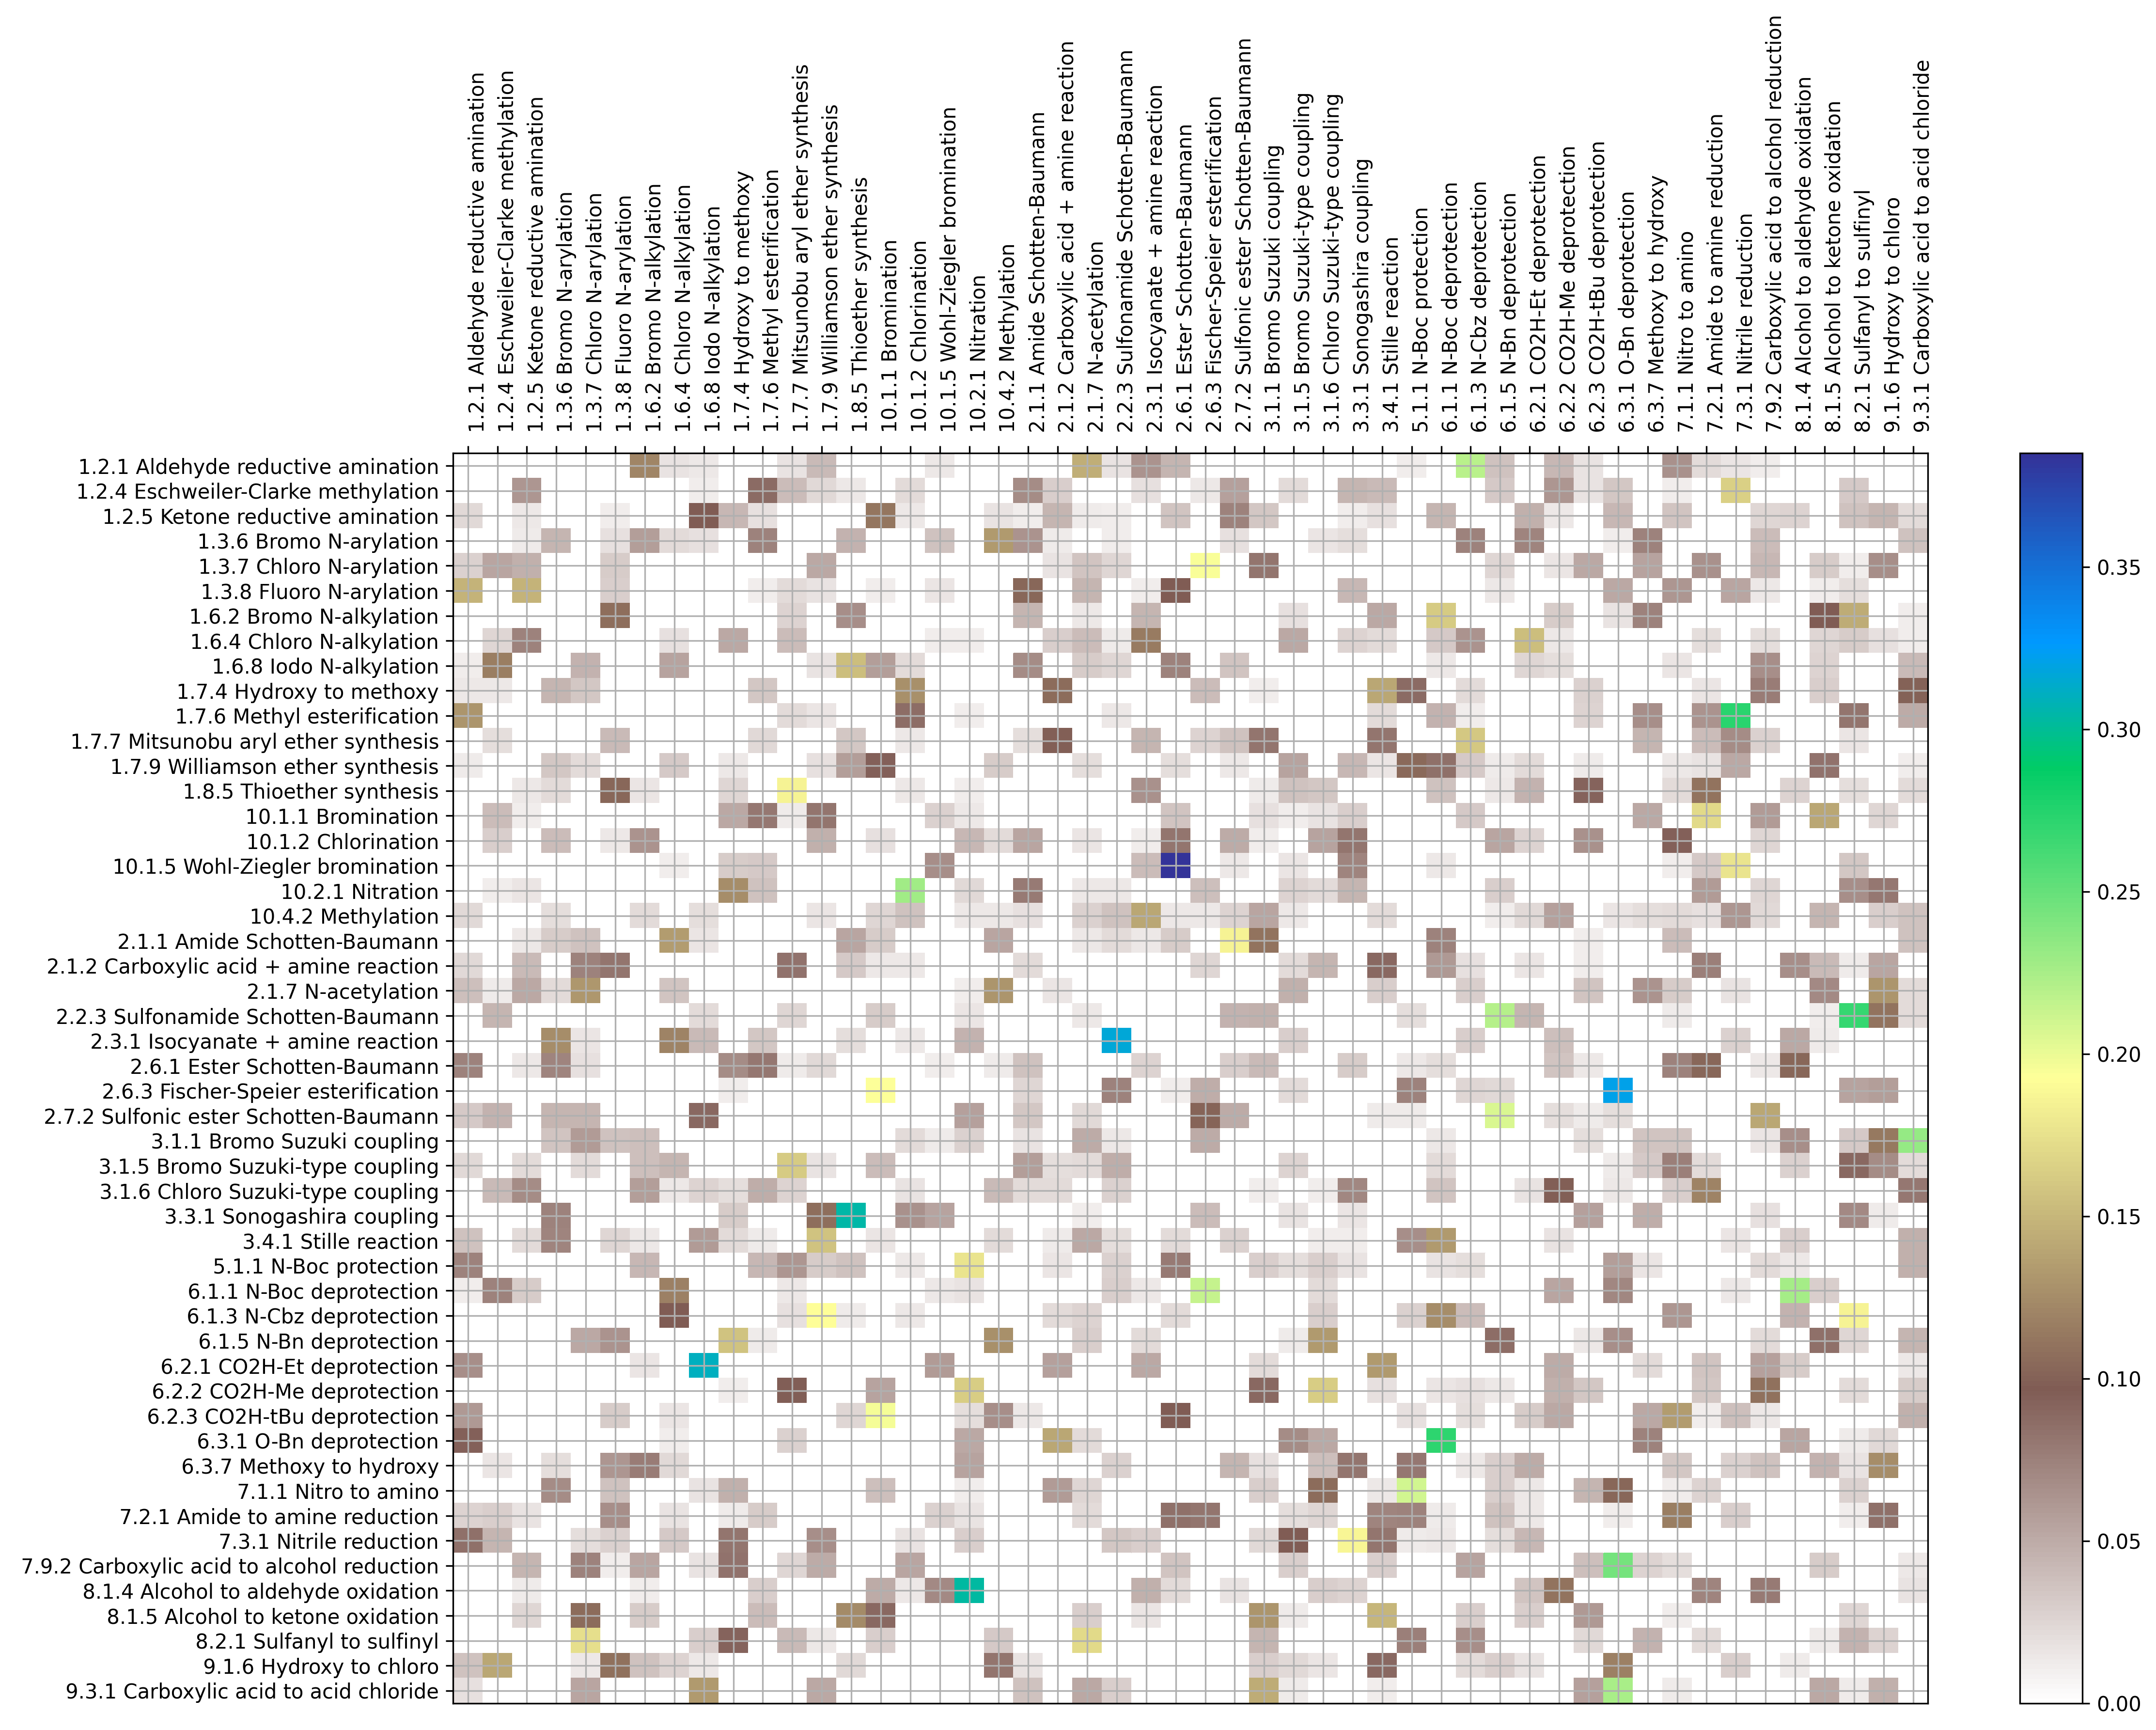

In [20]:
lr_cls =  LogisticRegression(max_iter=1000)

scrambled_train_rxn_ids = [rxnclass2id[c] for c in train_df.rxn_class]
test_rxn_class_ids = [rxnclass2id[c] for c in test_df.rxn_class]


random.seed(42)
random.shuffle(scrambled_train_rxn_ids)
lr_classifier_scrambled = lr_cls.fit(train_df.ft_10k.values.tolist(), scrambled_train_rxn_ids)
confusion_matrix_scrambled = evaluate_model(lr_classifier_scrambled, test_df.ft_10k.values.tolist(), test_rxn_class_ids, all_classes, rxnclass2name)
fig = labelled_cmat(confusion_matrix_scrambled, 
                    all_classes,
                    figsize=(16,12), label_extras=rxnclass2name)

### Evaluación y Visualización de Resultados
Una vez que el modelo ha sido entrenado, utilizamos la función evaluate_model para calcular métricas clave como recall, precision y F-score para cada clase de reacción. Estas métricas nos dan una idea de qué tan bien el modelo puede predecir las reacciones químicas.

Finalmente, generamos una matriz de confusión con labelled_cmat, que nos permite visualizar cómo el modelo está clasificando las reacciones. 
* Las diagonales representan las predicciones correctas, mientras que los valores fuera de la diagonal indican errores de clasificación.

Este análisis nos ayuda a identificar si el modelo tiene dificultades para diferenciar entre ciertas clases de reacciones químicas.

 & recall & prec & F-score  &   reaction class &  \\ 
 0 & 0.9988 & 0.9901 &0.9944 & Aldehyde reductive amination &1.2.1 \\
 1 & 0.9712 & 0.9848 &0.9780 & Eschweiler-Clarke methylation &1.2.4 \\
 2 & 0.9888 & 0.9950 &0.9918 & Ketone reductive amination &1.2.5 \\
 3 & 0.9912 & 0.9863 &0.9888 & Bromo N-arylation &1.3.6 \\
 4 & 0.9962 & 0.9827 &0.9894 & Chloro N-arylation &1.3.7 \\
 5 & 0.9975 & 0.9876 &0.9925 & Fluoro N-arylation &1.3.8 \\
 6 & 0.9825 & 0.9788 &0.9807 & Bromo N-alkylation &1.6.2 \\
 7 & 0.9437 & 0.9921 &0.9673 & Chloro N-alkylation &1.6.4 \\
 8 & 0.9838 & 0.9825 &0.9831 & Iodo N-alkylation &1.6.8 \\
 9 & 0.9775 & 0.9678 &0.9726 & Hydroxy to methoxy &1.7.4 \\
10 & 0.9838 & 0.9838 &0.9838 & Methyl esterification &1.7.6 \\
11 & 0.9675 & 0.9639 &0.9657 & Mitsunobu aryl ether synthesis &1.7.7 \\
12 & 0.9750 & 0.9665 &0.9708 & Williamson ether synthesis &1.7.9 \\
13 & 0.9938 & 0.9938 &0.9938 & Thioether synthesis &1.8.5 \\
14 & 0.9575 & 0.9935 &0.9752 & Bromination &10.1.1 \\


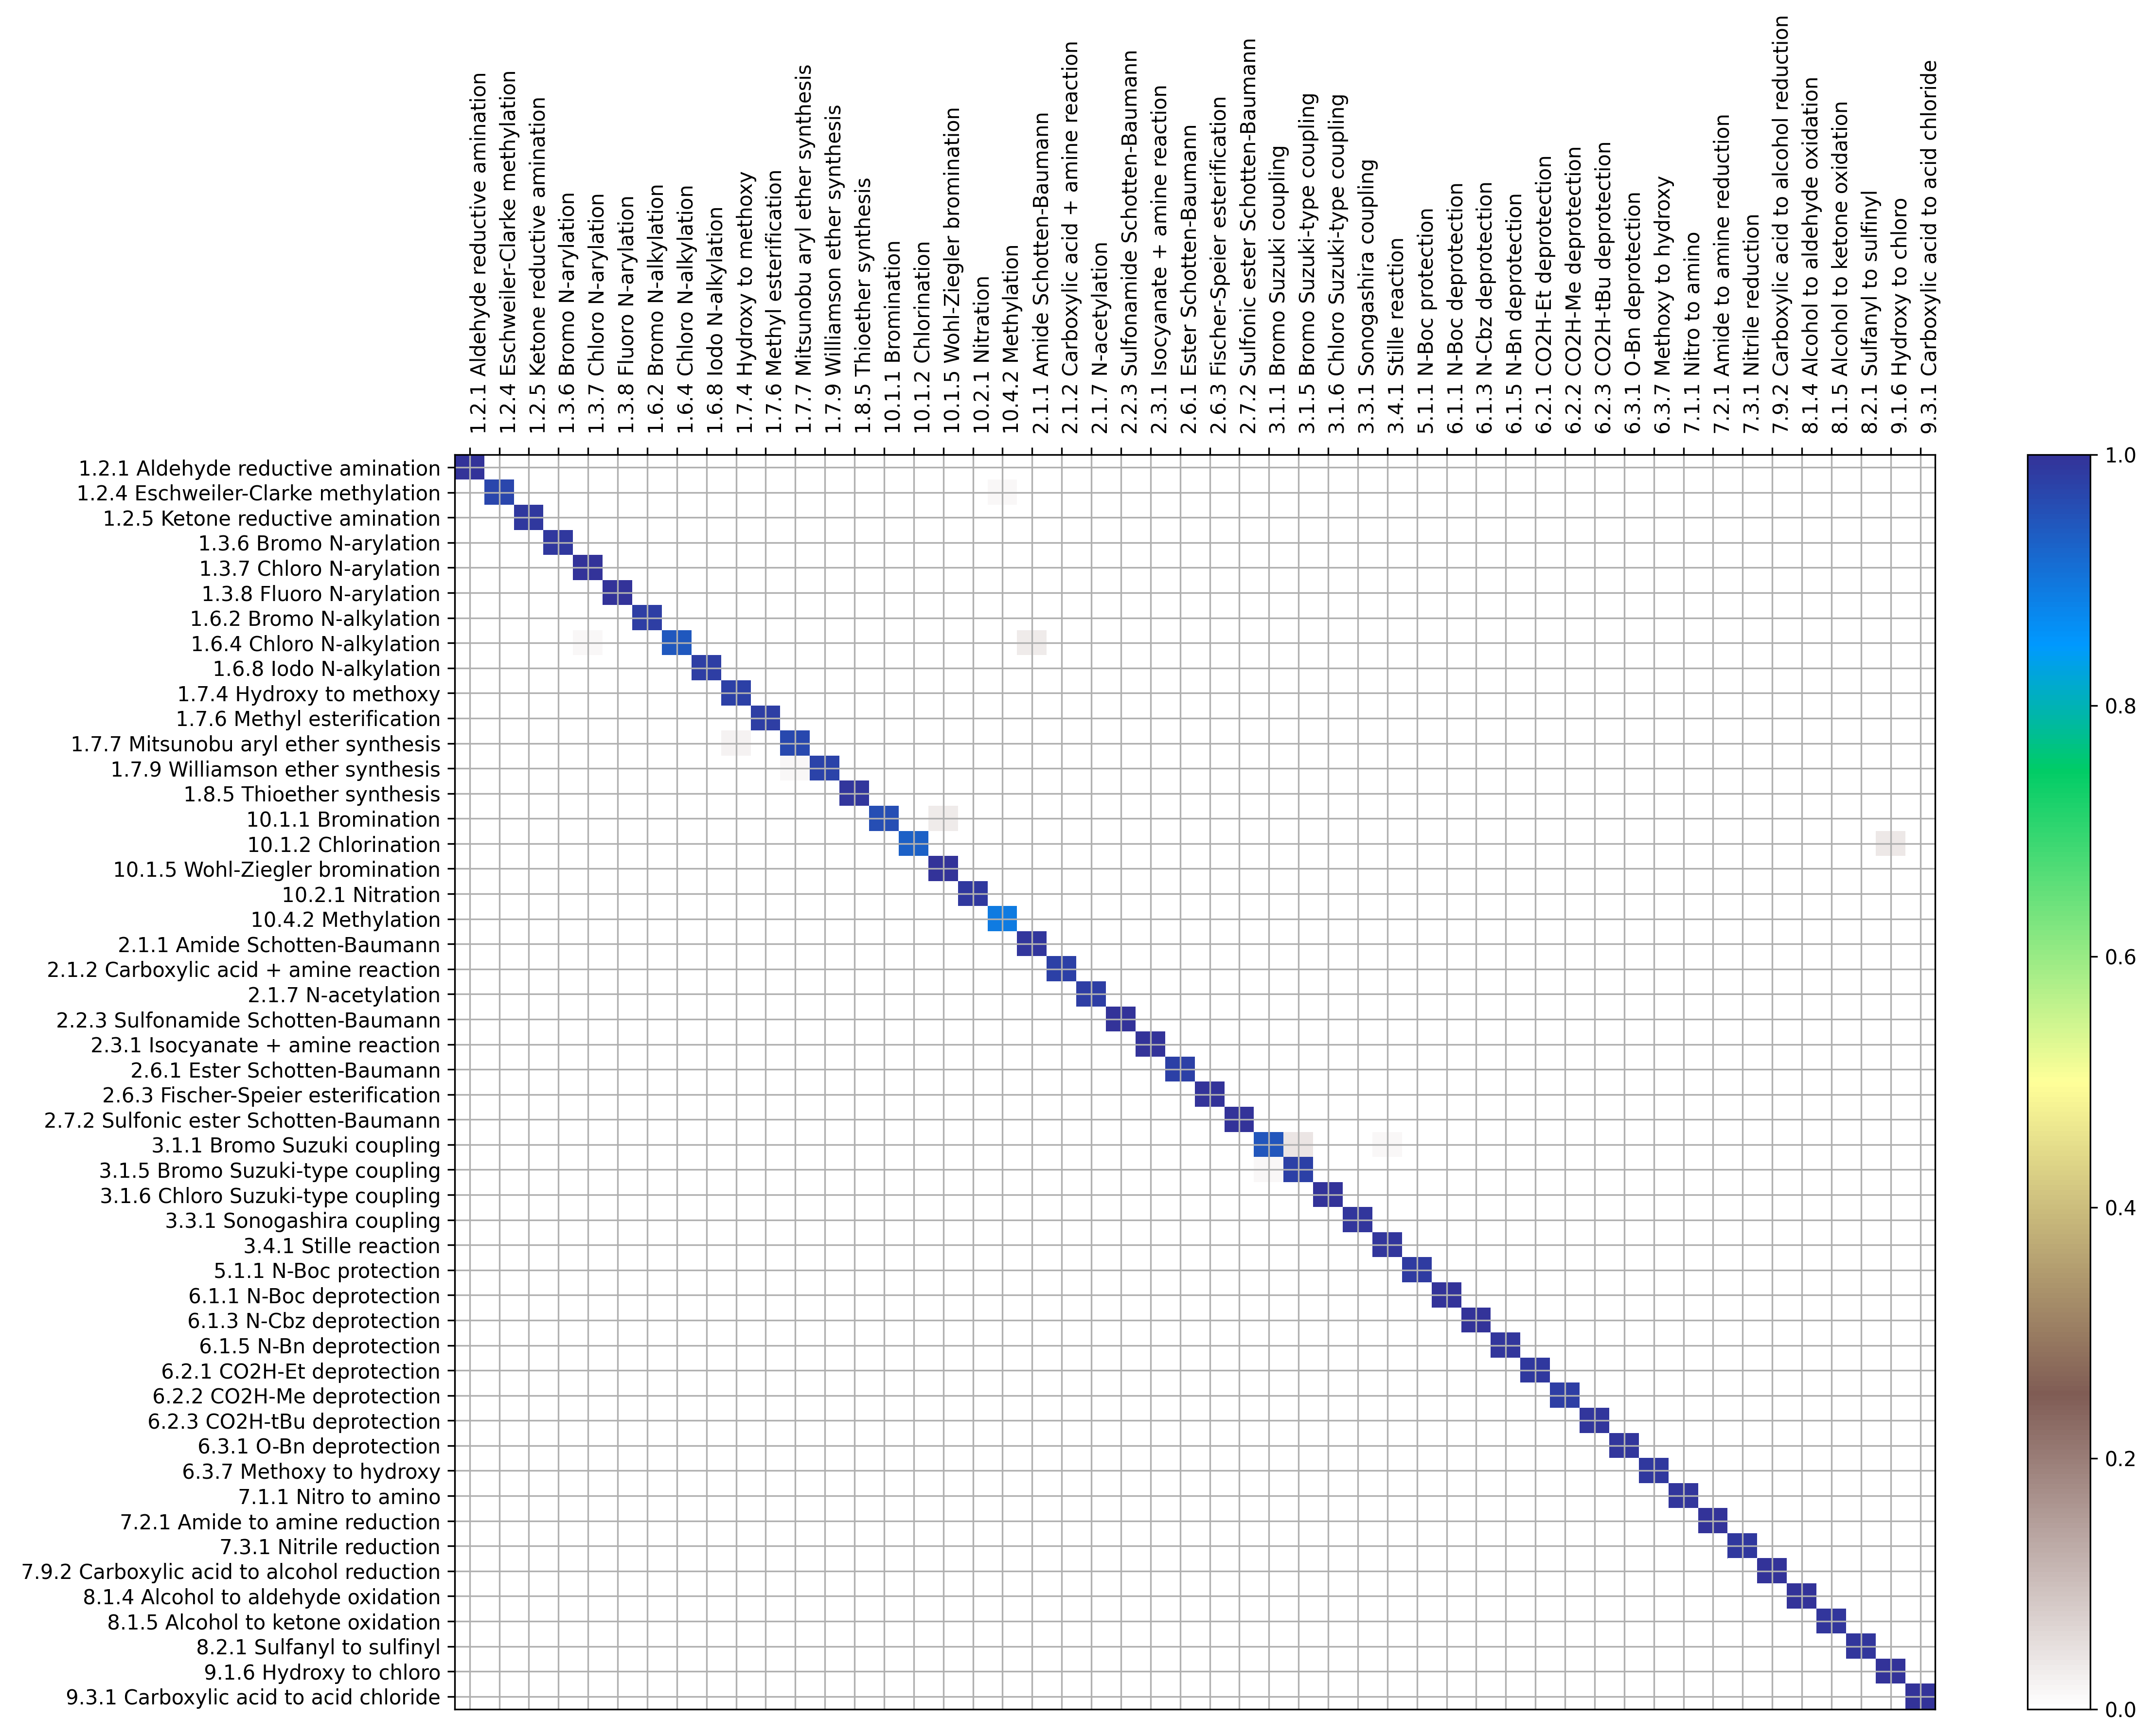

In [21]:
lr_cls =  LogisticRegression(max_iter=5000)
lr_classifier_ft_10k_trained = lr_cls.fit(train_df.ft_10k.values.tolist(), train_df.class_id.values.tolist())
confusion_matrix_ft_10k = evaluate_model(lr_classifier_ft_10k_trained, test_df.ft_10k.values.tolist(), test_rxn_class_ids, all_classes, rxnclass2name)
fig = labelled_cmat(confusion_matrix_ft_10k, 
                    all_classes,
                    figsize=(16,12), label_extras=rxnclass2name)

RXNFP pretrained
This reaction fingerprint was only pretrained on a large set of reaction SMILES

 & recall & prec & F-score  &   reaction class &  \\ 
 0 & 0.9012 & 0.8990 &0.9001 & Aldehyde reductive amination &1.2.1 \\
 1 & 0.8063 & 0.8323 &0.8190 & Eschweiler-Clarke methylation &1.2.4 \\
 2 & 0.9213 & 0.9224 &0.9218 & Ketone reductive amination &1.2.5 \\
 3 & 0.8600 & 0.8632 &0.8616 & Bromo N-arylation &1.3.6 \\
 4 & 0.8712 & 0.7929 &0.8303 & Chloro N-arylation &1.3.7 \\
 5 & 0.9200 & 0.9497 &0.9346 & Fluoro N-arylation &1.3.8 \\
 6 & 0.8113 & 0.8353 &0.8231 & Bromo N-alkylation &1.6.2 \\
 7 & 0.7600 & 0.7696 &0.7648 & Chloro N-alkylation &1.6.4 \\
 8 & 0.8125 & 0.7908 &0.8015 & Iodo N-alkylation &1.6.8 \\
 9 & 0.8500 & 0.8662 &0.8580 & Hydroxy to methoxy &1.7.4 \\
10 & 0.9200 & 0.9258 &0.9229 & Methyl esterification &1.7.6 \\
11 & 0.8413 & 0.8519 &0.8465 & Mitsunobu aryl ether synthesis &1.7.7 \\
12 & 0.8000 & 0.7960 &0.7980 & Williamson ether synthesis &1.7.9 \\
13 & 0.9225 & 0.8881 &0.9050 & Thioether synthesis &1.8.5 \\
14 & 0.9437 & 0.9461 &0.9449 & Bromination &10.1.1 \\


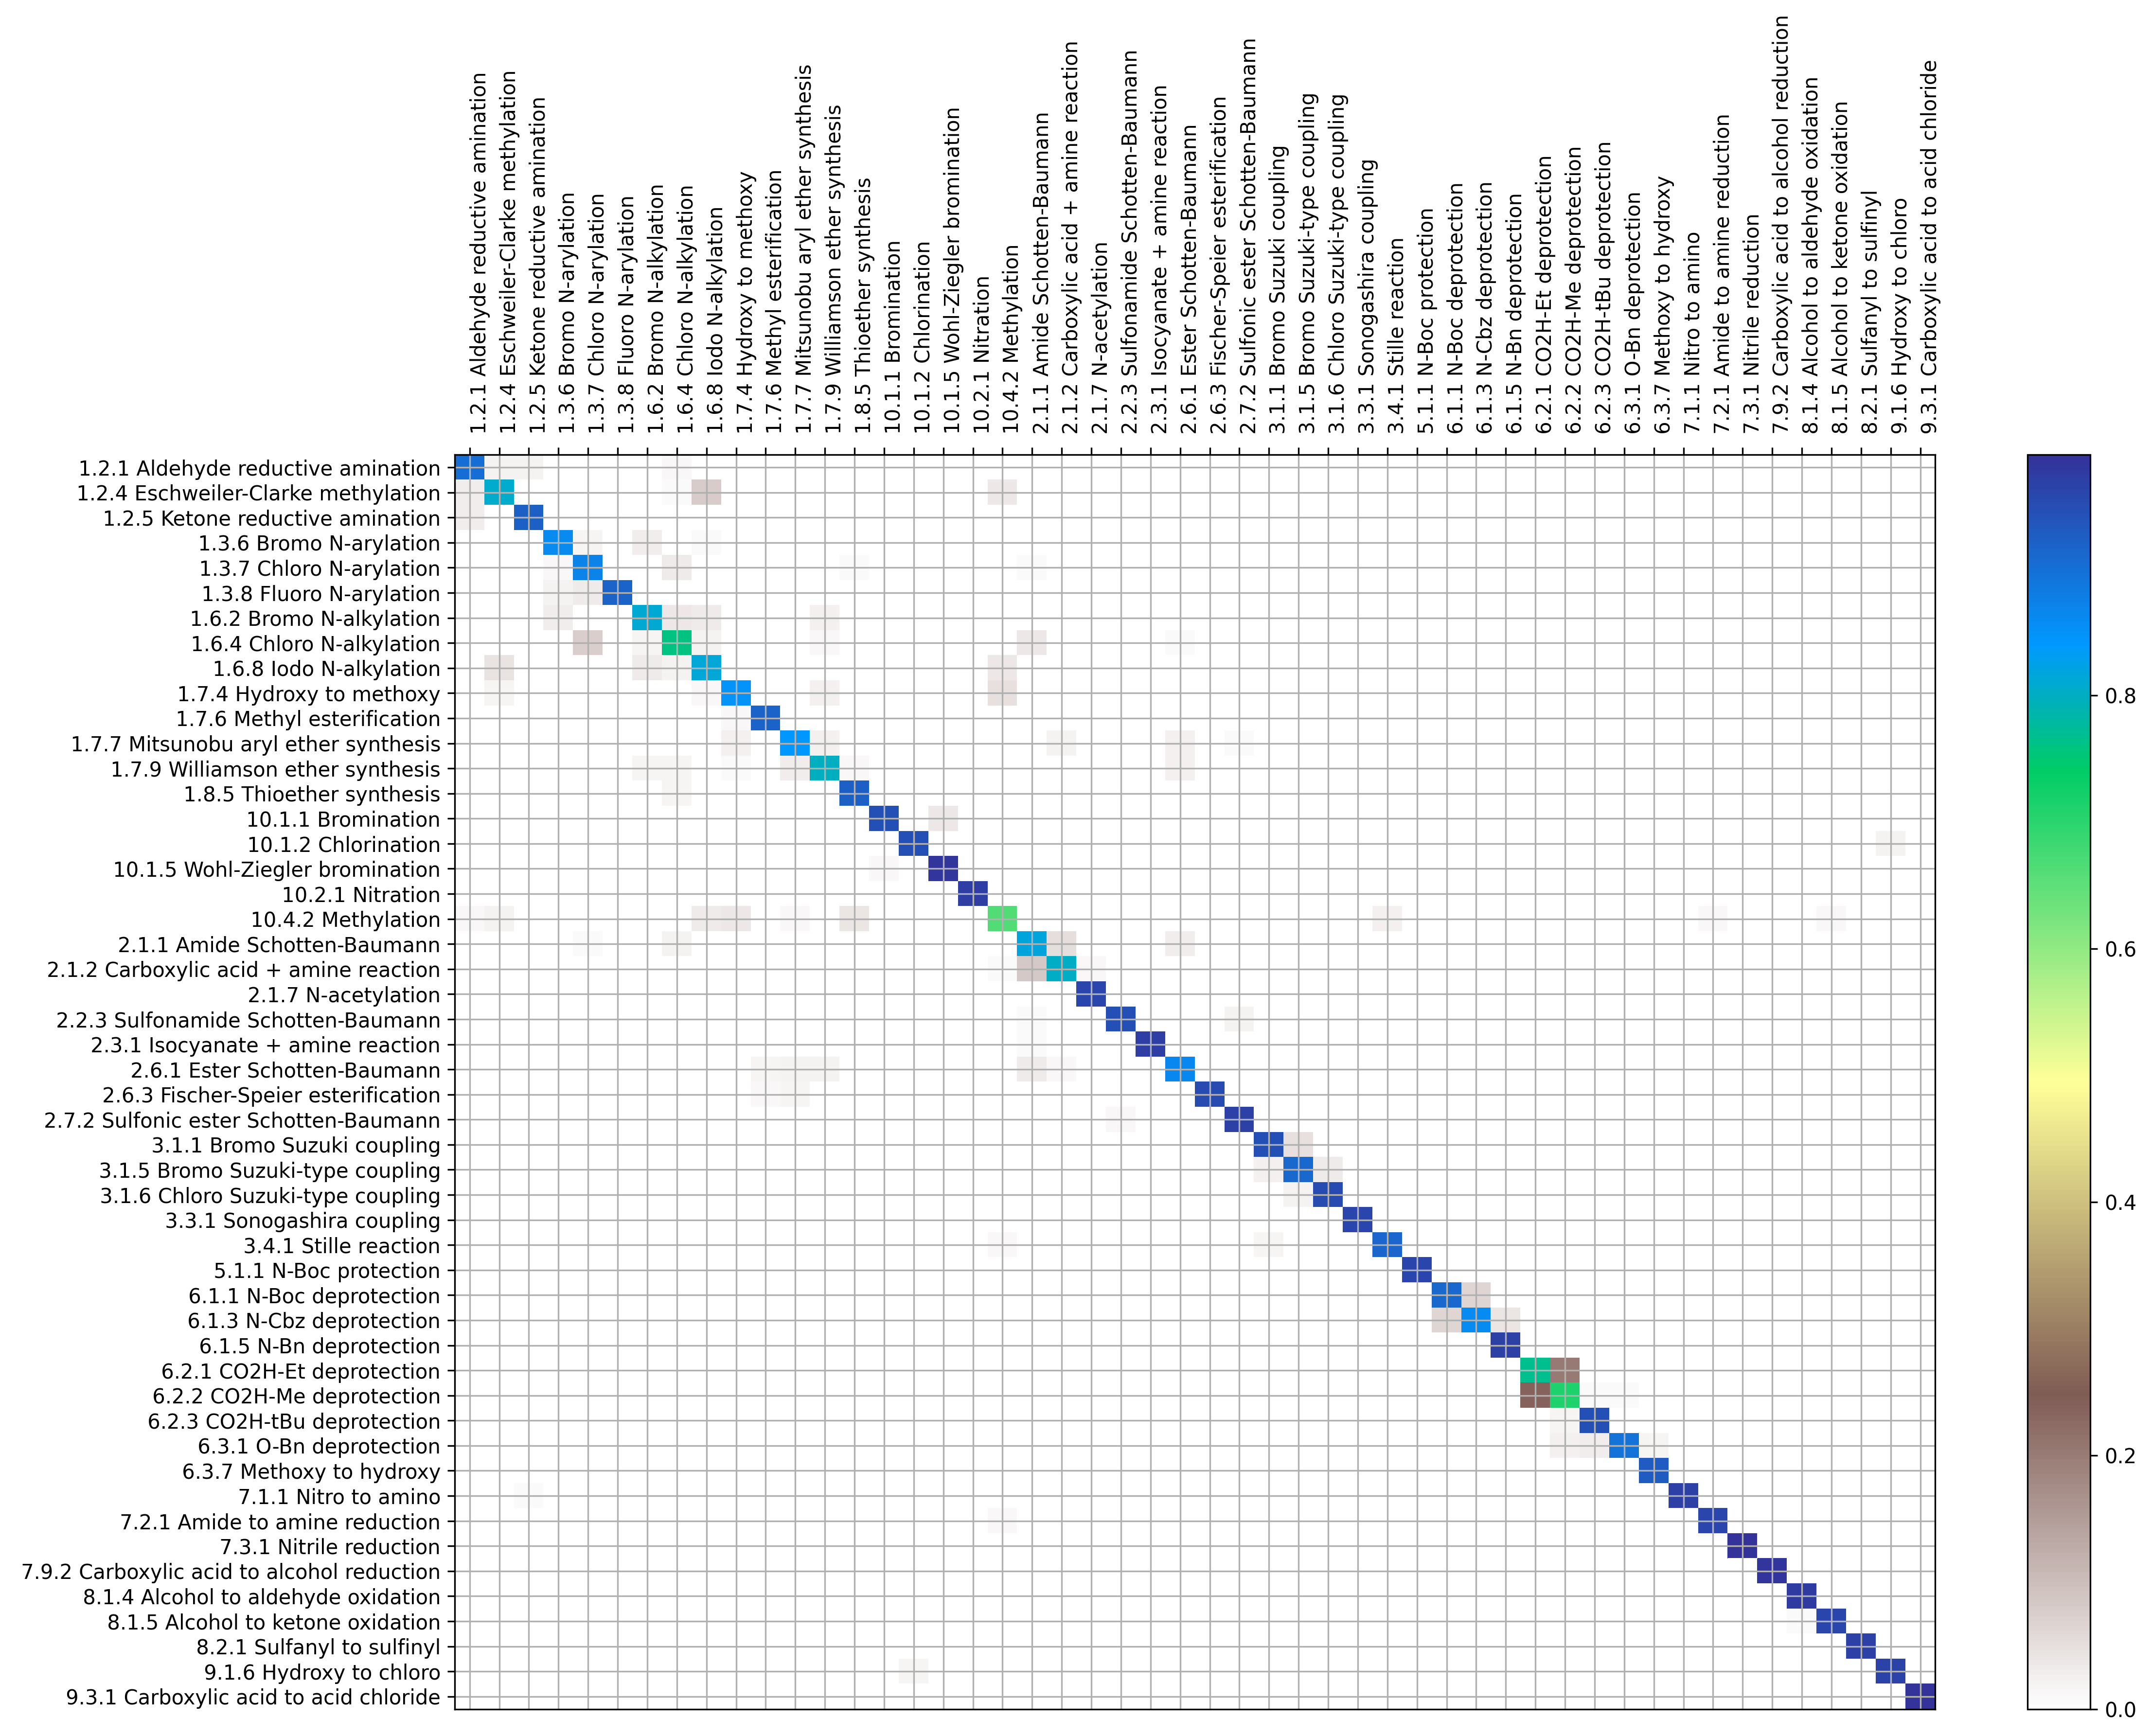

In [32]:
lr_cls =  LogisticRegression(max_iter=5000)
lr_classifier_ft_pretrained = lr_cls.fit(train_df.ft_pretrained.values.tolist(), train_df.class_id.values.tolist())
confusion_matrix_pretrained = evaluate_model(lr_classifier_ft_pretrained, test_df.ft_pretrained.values.tolist(), test_rxn_class_ids, all_classes, rxnclass2name)
fig = labelled_cmat(confusion_matrix_pretrained, 
                    all_classes,
                    figsize=(16,12), label_extras=rxnclass2name)

### Pretrained classifier predicting on fine-tuned fingerprints

This is another experiment that shows that for some of the classes the pretrained fingerprint contained already most of the information and the fine-tuning did not change how the BERT model would embed the class token.

 & recall & prec & F-score  &   reaction class &  \\ 
 0 & 0.1925 & 1.0000 &0.3229 & Aldehyde reductive amination &1.2.1 \\
 1 & 0.9400 & 0.9908 &0.9647 & Eschweiler-Clarke methylation &1.2.4 \\
 2 & 0.9925 & 0.9950 &0.9937 & Ketone reductive amination &1.2.5 \\
 3 & 0.0000 & 0.0000 &0.0000 & Bromo N-arylation &1.3.6 \\
 4 & 0.0000 & 0.0000 &0.0000 & Chloro N-arylation &1.3.7 \\
 5 & 0.1025 & 1.0000 &0.1859 & Fluoro N-arylation &1.3.8 \\
 6 & 0.0000 & 0.0000 &0.0000 & Bromo N-alkylation &1.6.2 \\
 7 & 0.0312 & 0.0469 &0.0375 & Chloro N-alkylation &1.6.4 \\
 8 & 0.0000 & 0.0000 &0.0000 & Iodo N-alkylation &1.6.8 \\
 9 & 0.0000 & 0.0000 &0.0000 & Hydroxy to methoxy &1.7.4 \\
10 & 0.9875 & 0.4263 &0.5956 & Methyl esterification &1.7.6 \\
11 & 0.9400 & 0.2229 &0.3604 & Mitsunobu aryl ether synthesis &1.7.7 \\
12 & 0.8237 & 0.9321 &0.8746 & Williamson ether synthesis &1.7.9 \\
13 & 0.9838 & 0.9937 &0.9887 & Thioether synthesis &1.8.5 \\
14 & 0.9875 & 0.4256 &0.5949 & Bromination &10.1.1 \\


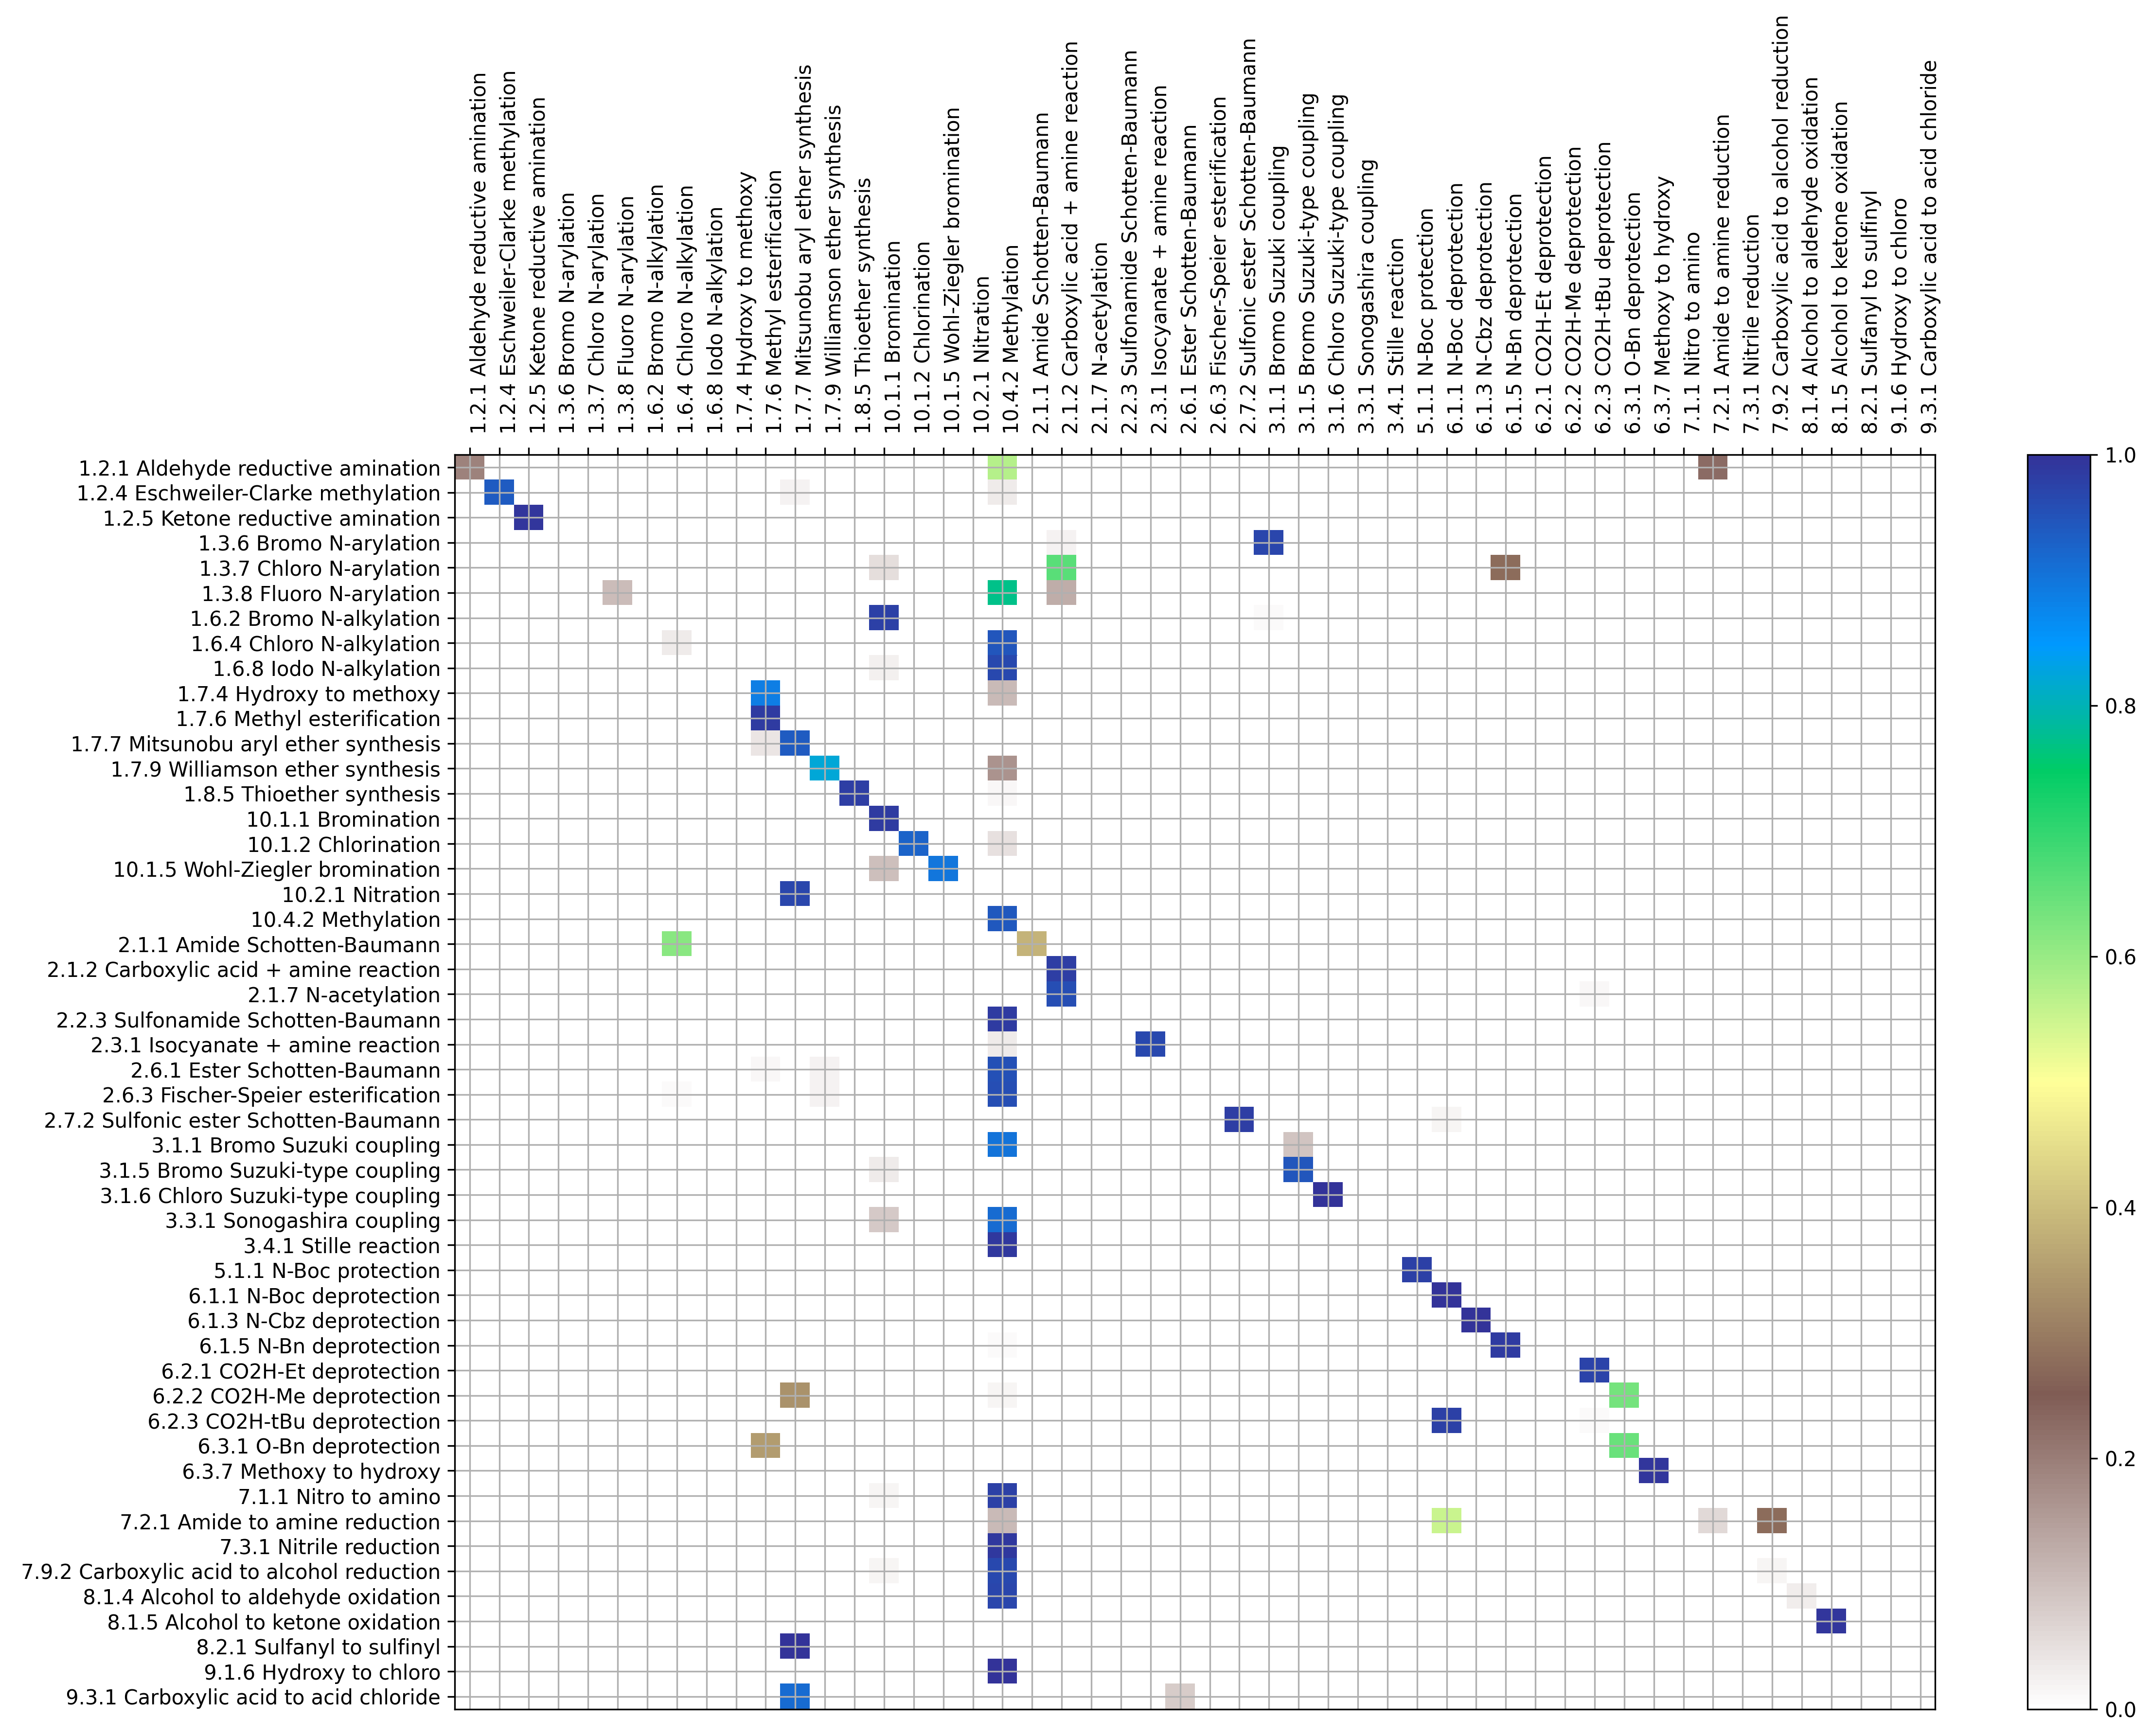

In [33]:
confusion_matrix_pretrained = evaluate_model(lr_classifier_ft_pretrained, test_df.ft_10k.values.tolist(), test_rxn_class_ids, all_classes, rxnclass2name)
fig = labelled_cmat(confusion_matrix_pretrained, 
                    all_classes,
                    figsize=(16,12), label_extras=rxnclass2name)

### Resultados - TMAP

Agrupamiento de las 50 mil reaacciones del Data_Set usando TMAP


In [34]:
import json
import numpy as np
import pandas as pd
import tmap as tm
from tqdm import tqdm 
from faerun import Faerun
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from scipy import stats
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Descriptors3D
from matplotlib.colors import LinearSegmentedColormap

In [35]:
lf = tm.LSHForest(256, 128)
mh_encoder = tm.Minhash()

In [36]:
with open('rxnfp/data/rxnclass2name.json', 'r') as f:
    rxnclass2name = json.load(f)
schneider_df = pd.read_csv('rxnfp/data/schneider50k.tsv', sep='\t', index_col=0)
ft_10k_fps = np.load('rxnfp/data/fps_ft_10k.npz')['fps']
schneider_df['rxn_category'] = schneider_df.rxn_class.apply(lambda x: '.'.join(x.split('.')[:2]))
schneider_df['rxn_superclass'] = schneider_df.rxn_class.apply(lambda x: x.split('.')[0])
schneider_df.head()

original_rxn rxn_class      source  \
0  [CH3:17][S:14](=[O:15])(=[O:16])[N:11]1[CH2:10...     6.1.5  US06887874   
1  O.O.[Na+].[CH3:1][c:2]1[cH:7][c:6]([N+:8](=O)[...     7.1.1  US07056926   
2  [CH3:1][O:2][c:3]1[cH:4][cH:5][c:6](-[c:9]2[cH...     1.8.5  US08492378   
3  Cl.[CH3:43][CH2:42][S:44](=[O:45])(=[O:46])Cl....     2.2.3  US08592454   
4  [CH3:25][O:24][c:21]1[cH:22][cH:23][c:17]([O:1...     1.3.7  US06716851   

                                                 rxn  split rxn_category  \
0  C1CCCCC1.CCO.CS(=O)(=O)N1CCN(Cc2ccccc2)CC1.[OH...   test          6.1   
1  CCOC(C)=O.Cc1cc([N+](=O)[O-])ccc1NC(=O)c1ccccc...   test          7.1   
2  COc1ccc(-c2coc3ccc(-c4nnc(S)o4)cc23)cc1.COc1cc...   test          1.8   
3  CCS(=O)(=O)Cl.CN(C(=O)N(C)[C@@H]1CN(C(=O)C2CCN...  train          2.2   
4  COc1ccc(OC)c(N)c1.Cc1cc(Cl)nc(-c2ccccn2)n1>>CO...   test          1.3   

  rxn_superclass  
0              6  
1              7  
2              1  
3              2  
4              1

In [37]:
mhfps = [mh_encoder.from_weight_array(fp.tolist(), method="I2CWS") for fp in tqdm(ft_10k_fps)]

100%|██████████| 50000/50000 [00:25<00:00, 1962.06it/s]


Calcular las propiedades de Rxn

In [40]:

labels = []
# superclasses
superclasses = []

# product properties
tpsa = []
logp = []
mw = []
h_acceptors = []
h_donors = []
ring_count = []

# metals in precursors
has_Pd = []
has_Li = []
has_Mg = []
has_Al = []

for i, row in tqdm(schneider_df.iterrows(), total=len(schneider_df)):

    rxn = row["rxn"]
    labels.append(
        str(rxn)
        + "__"
        + str(rxn)
        + f"__{row['source']}"
        + f"__{rxnclass2name[row['rxn_class']]} - {row['rxn_class']}"
        + f"__{rxnclass2name[row['rxn_category']]}"
        + f"__{rxnclass2name[row['rxn_superclass']]}"
    )
    superclasses.append(int(row["rxn_superclass"]))
    
    precursors, products = rxn.split('>>')

    mol = Chem.MolFromSmiles(products)
            
    tpsa.append(Descriptors.TPSA(mol))
    logp.append(Descriptors.MolLogP(mol))
    mw.append(Descriptors.MolWt(mol))
    h_acceptors.append(Descriptors.NumHAcceptors(mol))
    h_donors.append(Descriptors.NumHDonors(mol))
    ring_count.append(Descriptors.RingCount(mol))
    
    has_Pd.append('Pd' in precursors)
    has_Li.append('Li' in precursors)
    has_Mg.append('Mg' in precursors)
    has_Al.append('Al' in precursors)
tpsa_ranked = stats.rankdata(np.array(tpsa) / max(tpsa)) / len(tpsa)
logp_ranked = stats.rankdata(np.array(logp) / max(logp)) / len(logp)
mw_ranked = stats.rankdata(np.array(mw) / max(mw)) / len(mw)
h_acceptors_ranked = stats.rankdata(np.array(h_acceptors) / max(h_acceptors)) / len(
    h_acceptors
)
h_donors_ranked = stats.rankdata(np.array(h_donors) / max(h_donors)) / len(h_donors)
ring_count_ranked = stats.rankdata(np.array(ring_count) / max(ring_count)) / len(
    ring_count
)
labels_groups, groups = Faerun.create_categories(superclasses)

labels_groups = [(label[0], f"{label[1]} - {rxnclass2name[str(label[1])]}") for label in labels_groups]

  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [01:24<00:00, 589.38it/s]


 ### Configuración de un Bosque de Hash Local Sensible
 Búsqueda de vecinos más cercanos y la reducción de dimensionalidad en grandes conjuntos de datos, particularmente en el contexto de la búsqueda y comparación de vectores de características.

In [41]:
lf.batch_add(mhfps)
lf.index()

# Layout
cfg = tm.LayoutConfiguration()
cfg.k = 50
cfg.kc = 50
cfg.sl_scaling_min = 1.0
cfg.sl_scaling_max = 1.0
cfg.sl_repeats = 1
cfg.sl_extra_scaling_steps = 2
cfg.placer = tm.Placer.Barycenter
cfg.merger = tm.Merger.LocalBiconnected
cfg.merger_factor = 2.0
cfg.merger_adjustment = 0
cfg.fme_iterations = 1000
cfg.sl_scaling_type = tm.ScalingType.RelativeToDesiredLength
cfg.node_size = 1 / 37
cfg.mmm_repeats = 1

# Define colormaps
set1 = plt.get_cmap("Set1").colors
rainbow = plt.get_cmap("rainbow")
colors = rainbow(np.linspace(0, 1, len(set(groups))))[:, :3].tolist()
custom_cm = LinearSegmentedColormap.from_list("my_map", colors, N=len(colors))
bin_cmap = ListedColormap([set1[8], "#5400F6"], name="bin_cmap")

# Get tree coordinates
x, y, s, t, _ = tm.layout_from_lsh_forest(lf, config=cfg)

### Crear un Mapa o gráfica "Fearun"

In [42]:

# slow
f = Faerun(clear_color="#ffffff", coords=False, view="front",)
    
f.add_scatter(
"ReactionAtlas",
{
    "x": x, "y": y, 
    "c": [
        groups, # superclasses
        has_Pd, 
        has_Li, 
        has_Mg, 
        has_Al,
        tpsa_ranked,
        logp_ranked,
        mw_ranked,
        h_acceptors_ranked,
        h_donors_ranked,
        ring_count_ranked,
    ], 
    "labels": labels
},
shader="smoothCircle",
colormap=[
    custom_cm, 
    bin_cmap, 
    bin_cmap, 
    bin_cmap, 
    bin_cmap, 
    "rainbow",
    "rainbow",
    "rainbow",
    "rainbow",
    "rainbow",
    "rainbow",

],
point_scale=2.0,
categorical=[
    True, 
    True, 
    True, 
    True, 
    True, 
    False, 
    False, 
    False, 
    False, 
    False, 
    False, 
],
has_legend=True,
legend_labels=[
    labels_groups,
    [(0, "No"), (1, "Yes")],
    [(0, "No"), (1, "Yes")],
    [(0, "No"), (1, "Yes")],
    [(0, "No"), (1, "Yes")],
    None,
    None,
    None,
    None,
    None,
    None,
],
selected_labels=["SMILES", "SMILES", "Patent ID",  "Named Reaction", "Category", "Superclass"],
series_title=[
    "Superclass", 
    "Pd", 
    "Li", 
    "Mg", 
    "Al",
    "TPSA",
    "logP",
    "Mol Weight",
    "H Acceptors",
    "H Donors",
    "Ring Count",
],
max_legend_label=[
    None,
    None,
    None,
    None,
    None,
    str(round(max(tpsa))),
    str(round(max(logp))),
    str(round(max(mw))),
    str(round(max(h_acceptors))),
    str(round(max(h_donors))),
    str(round(max(ring_count))),
],
min_legend_label=[
    None,
    None,
    None,
    None,
    None,
    str(round(min(tpsa))),
    str(round(min(logp))),
    str(round(min(mw))),
    str(round(min(h_acceptors))),
    str(round(min(h_donors))),
    str(round(min(ring_count))),
],
title_index=2,
legend_title="",
)

f.add_tree("reactiontree", {"from": s, "to": t}, point_helper="ReactionAtlas")

/home/jesus_gh/miniconda3/envs/rxnfp/lib/python3.6/site-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


In [43]:
# hide
# slow
plot = f.plot("ft_10k_schneider_50k", template="reaction_smiles")

/home/jesus_gh/MetodosBiomAI/CasoPractico_2/ft_10k_schneider_50k.html